# Лабораторная работа №2 “Логистическая регрессия. Многоклассовая классификация”

### *Набор данных **ex2data1.txt** представляет собой текстовый файл, содержащий информацию об оценке студента по первому экзамену (первое число в строке), оценке по второму экзамену (второе число в строке) и поступлении в университет (0 - не поступил, 1 - поступил).*
### *Набор данных **ex2data2.txt** представляет собой текстовый файл, содержащий информацию о результате первого теста (первое число в строке) и результате второго теста (второе число в строке) изделий и результате прохождения контроля (0 - контроль не пройден, 1 - контроль пройден).*
### *Набор данных **ex2data3.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 5000 изображений 20x20 в оттенках серого. Каждый пиксель представляет собой значение яркости (вещественное число). Каждое изображение сохранено в виде вектора из 400 элементов. В результате загрузки набора данных должна быть получена матрица 5000x400. Далее расположены метки классов изображений от 1 до 9 (соответствуют цифрам от 1 до 9), а также 10 (соответствует цифре 0).*

## **Задание**

### 1. Загрузите данные **ex2data1.txt** из текстового файла.

In [138]:
from copy import deepcopy
from collections import OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import io
from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [55]:
ex2data1 = np.loadtxt('Data/Lab 2/ex2data1.txt', delimiter=',')
X, y = ex2data1[:, :2], ex2data1[:, 2]

### 2. Постройте график, где по осям откладываются оценки по предметам, а точки обозначаются двумя разными маркерами в зависимости от того, поступил ли данный студент в университет или нет.

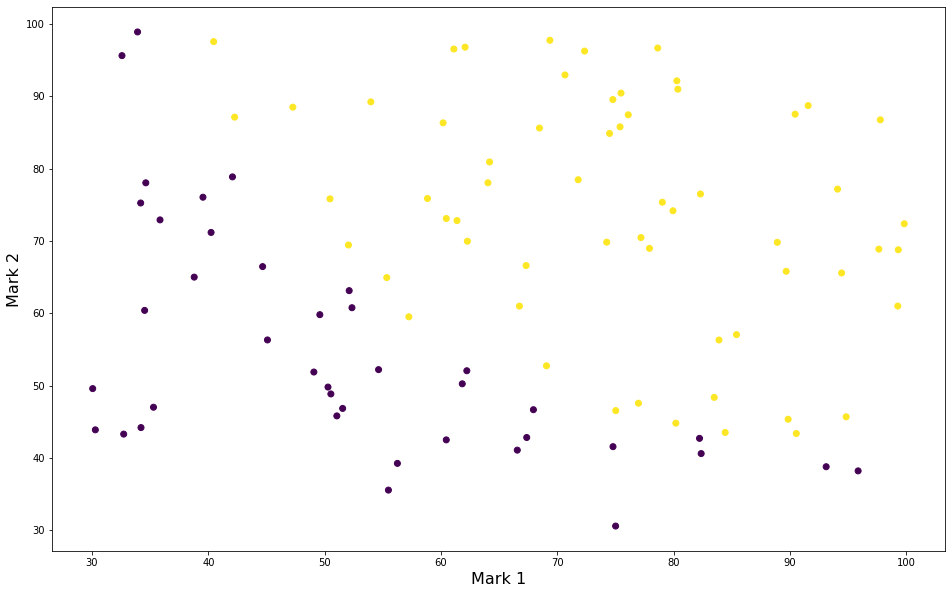

In [56]:
plt.figure(figsize=(16, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Mark 1', size=16)
plt.ylabel('Mark 2', size=16)
plt.show()

### 3. Реализуйте функции потерь J(θ) и градиентного спуска для логистической регрессии с использованием векторизации.

In [57]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def get_initialization(dim, eps=1e-4, concat=False):
    Z = np.random.uniform(-eps, eps, size=dim+1)
    
    if concat:
        return Z
    else:
        return Z[:-1], Z[-1]
    
class LogisticRegression:
    
    def __init__(self, W, b):
        self.W, self.b = W, b
    
    def __call__(self, X):
        Z = np.dot(X, self.W) + self.b
        return sigmoid(Z).flatten()
    
    def __repr__(self):
        return str(self.W.tolist() + [self.b])
    
    def loss(self, X, y):
        A = np.clip(self(X), 1e-6, 1. - 1e-6)
        return -np.mean(y * np.log(A) + (1.-y) * np.log(1.0 - A))
    
    def grad(self, X, y):
        m = X.shape[0]
        A = self(X)
        
        dw = np.dot(X.T, A - y) * (1.0/m)
        db = np.mean(A - y)

        return dw, db

In [58]:
def get_gradient_descent(model, alpha, eps, stop_loss=True):
    def apply(X, y):
        iter_num = 0
        need_stop = False
        
        initial_loss = loss_before = loss_after = model.loss(X, y)
        steps = [initial_loss]
        
        while not need_stop:
            dW, db = model.grad(X, y)
            assert dW.shape == model.W.shape
            
            model.W -= alpha * dW
            model.b -= alpha * db

            loss_after = model.loss(X, y)
            assert loss_before >= loss_after, (loss_before, loss_after)
            
            if stop_loss:
                need_stop = loss_before - loss_after <= eps
            else:
                need_stop = np.linalg.norm(dW) <= eps and db <= eps
            
            loss_before = loss_after
            steps.append(loss_after)
                
            iter_num += 1
        
        return {
            "initial_loss": initial_loss,
            "loss_after": loss_after,
            "loss_steps": steps,
            "model": model,
            "iter_num": iter_num
        }
    
    return apply

### 4. Реализуйте другие методы (как минимум 2) оптимизации для реализованной функции стоимости (например, Метод Нелдера — Мида, Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно, генетические методы и т.п.). Разрешается использовать библиотечные реализации методов оптимизации (например, из библиотеки scipy).

In [59]:
def optim_func(X, y):
    def F(z):
        W, b = z[:-1], z[-1]
        model = LogisticRegression(W, b)
        return model.loss(X, y)
    
    return F

def optim_func_grad(X, y):
    def G(z):
        W, b = z[:-1], z[-1]
        model = LogisticRegression(W, b)
        dW, db = model.grad(X, y)
        return np.array(dW.tolist() + [db])
    
    return G

z0 = get_initialization(dim=X.shape[1], concat=True)

func = optim_func(X, y)
func_grad = optim_func_grad(X, y)

In [60]:
minimize(func, z0, jac=func_grad, method='L-BFGS-B')

      fun: 0.2034977015901526
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.48293201e-06, -1.44166168e-06, -5.95160324e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 35
      nit: 31
   status: 0
  success: True
        x: array([  0.20623222,   0.20147217, -25.16140078])

In [61]:
minimize(func, z0, method='Powell')

   direc: array([[ 1.07846216e-01,  6.29961395e-02, -1.06952770e+01],
       [ 4.72176373e-02,  5.51604251e-02, -6.64725302e+00],
       [ 5.46784439e-05,  5.78584973e-04, -3.14404379e-02]])
     fun: 0.20349772709134156
 message: 'Optimization terminated successfully.'
    nfev: 415
     nit: 10
  status: 0
 success: True
       x: array([  0.20615413,   0.20142747, -25.15424483])

In [62]:
minimize(func, z0, method='CG')

     fun: 0.20349770465920294
     jac: array([4.71249223e-07, 4.04193997e-07, 1.32992864e-06])
 message: 'Optimization terminated successfully.'
    nfev: 1045
     nit: 89
    njev: 209
  status: 0
 success: True
       x: array([  0.20619537,   0.20143484, -25.15679046])

### 5. Реализуйте функцию предсказания вероятности поступления студента в зависимости от значений оценок по экзаменам.

In [63]:
def predict(X, model):
    Z = np.dot(X, model.W) + model.b
    
    return sigmoid(Z).flatten()

In [64]:
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

model = LogisticRegression(*get_initialization(dim=X_norm.shape[1]))
gradient_descent = get_gradient_descent(model, 0.1, 1e-6)

model = gradient_descent(X_norm, y)['model']
predict(X_norm[[0, 3]], model)

array([0.10617451, 0.98562864])

### 6. Постройте разделяющую прямую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 2.

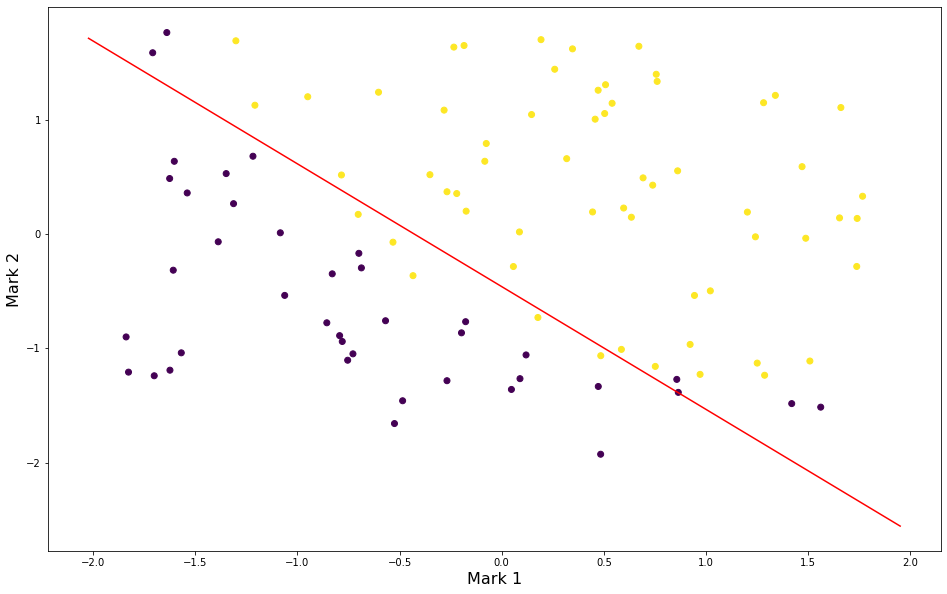

In [65]:
plt.figure(figsize=(16, 10))

plt.scatter(X_norm[:, 0], X_norm[:, 1], c=y, cmap='viridis')

ax = plt.gca()
xvals = np.array(ax.get_xlim()).reshape(-1, 1)
yvals = -(xvals * model.W[0] + model.b) / model.W[1]
plt.plot(xvals, yvals, color='r')

plt.xlabel('Mark 1', size=16)
plt.ylabel('Mark 2', size=16)
plt.show()

### 7. Загрузите данные **ex2data2.txt** из текстового файла.

In [103]:
ex2data2 = np.loadtxt('Data/Lab 2/ex2data2.txt', delimiter=',')
X, y = ex2data2[:, :2], ex2data2[:, 2]

### 8. Постройте график, где по осям откладываются результаты тестов, а точки обозначаются двумя разными маркерами в зависимости от того, прошло ли изделие контроль или нет.

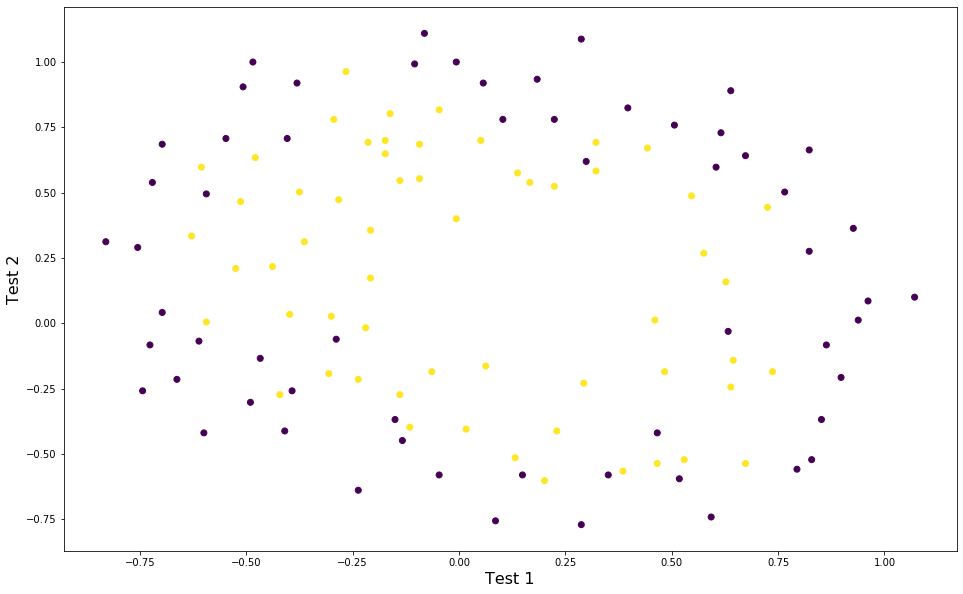

In [85]:
plt.figure(figsize=(16, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Test 1', size=16)
plt.ylabel('Test 2', size=16)
plt.show()

### 9. Постройте все возможные комбинации признаков x<sub>1</sub> (результат первого теста) и x<sub>2</sub> (результат второго теста), в которых степень полинома не превышает 6, т.е. 1, x<sub>1</sub>, x<sub>2</sub>, <sub>12</sub>, x<sub>1</sub>x<sub>2</sub>, x<sub>22</sub>, …, x<sub>1</sub>x<sub>25</sub>, x<sub>26</sub> (всего 28 комбинаций).

In [104]:
polynomial_transform = PolynomialFeatures(degree=6)

X_combinations = polynomial_transform.fit_transform(X)

### 10. Реализуйте L2-регуляризацию для логистической регрессии и обучите ее на расширенном наборе признаков методом градиентного спуска.

In [87]:
class L2RegualizedLogisticRegression(LogisticRegression):
    
    def __init__(self, W, b, C):
        super().__init__(W, b)
        self.C = C
    
    def loss(self, X, y):
        return super().loss(X, y) + 0.5 * self.C * np.sum(self.W**2)
    
    def grad(self, X, y):
        dW, db = super().grad(X, y)
        return dW + self.C * self.W, db

In [91]:
W, b = get_initialization(dim=X_wide.shape[1])
regularized_model = L2RegualizedLogisticRegression(W, b, 1e-4)

gradient_descent = get_gradient_descent(regularized_model, 0.1, 1e-6)
result = gradient_descent(X_combinations, y)
result['model']

[1.5668451897132667, 2.3013475359215874, 3.5638925213169883, -5.046428912986991, -4.1406203693634565, -5.136725511230286, 1.0038413608544055, -1.4700114001413258, -0.8574029678864368, -0.3774938875392601, -4.052305521964577, 0.35834593955922434, -2.166291385180579, -1.5743360509079143, -3.329131361527219, -0.6330927724351177, -0.6760285828807908, 0.5063238603583452, -1.3143477510975816, -1.5044927543257731, -0.15419709468921422, -3.233266474832206, 0.4091720116368199, -0.9466139019093851, 0.32991243432388934, -1.3127533079872935, -1.1874681758006636, -1.5314327489906285, 1.7089001900697496]

### 11. Реализуйте другие методы оптимизации.

In [94]:
def optim_func(X, y, C=1e-4):
    def F(z):
        W, b = z[:-1], z[-1]
        model = L2RegualizedLogisticRegression(W, b, C)
        return model.loss(X, y)
    
    return F

def optim_func_grad(X, y, C=1e-4):
    def G(z):
        W, b = z[:-1], z[-1]
        model = L2RegualizedLogisticRegression(W, b, C)
        dW, db = model.grad(X, y)
        return np.array(dW.tolist() + [db])
    
    return G

z0 = get_initialization(dim=X_combinations.shape[1], concat=True)

func = optim_func(X_combinations, y)
func_grad = optim_func_grad(X_combinations, y)

In [97]:
minimize(func, z0, jac=func_grad, method='L-BFGS-B')['x']

array([ 0.00996748,  2.07229049,  4.55056991, -5.49240141, -6.47140572,
       -6.11739045,  1.9823163 , -0.3119323 ,  2.12340186, -2.33978025,
       -3.84788891,  2.80300024, -3.49528629, -2.00624814, -5.82721889,
       -1.60341492, -0.76506965,  4.50240779, -3.36080355, -3.91194678,
        2.49211005, -5.15546904,  0.58365211, -0.85659057,  2.85863951,
       -4.04699632, -3.33296597,  0.20660741,  3.73987154])

In [98]:
minimize(func, z0, method='Powell')['x']

array([ 0.42392439,  2.3567425 ,  4.38351966, -5.89335346, -6.39705214,
       -6.72623677,  1.18845825,  0.01231515,  2.10568025, -1.80572372,
       -3.683573  ,  2.07766321, -3.40672257, -2.75368446, -5.43669065,
       -1.17413206, -0.61408624,  4.82064961, -3.14337323, -3.38109253,
        2.43257816, -4.78820592,  0.98060953, -0.64357582,  3.12889747,
       -4.01446145, -3.18457483,  0.04454178,  3.45073863])

In [99]:
minimize(func, z0, method='CG')['x']

array([ 0.12127361,  2.07602742,  4.55097027, -5.49813261, -6.47172159,
       -6.11765768,  1.97578396, -0.31776708,  2.11198803, -2.34229262,
       -3.85007636,  2.80542459, -3.49644311, -2.0075292 , -5.81995313,
       -1.61079426, -0.76547825,  4.51553424, -3.36153472, -3.91355398,
        2.50053087, -5.12765215,  0.59836705, -0.84864669,  2.84371691,
       -4.03618478, -3.31850301,  0.19067764,  3.62922599])

### 12. Реализуйте функцию предсказания вероятности прохождения контроля изделием в зависимости от результатов тестов.

In [108]:
def predict(X, model):
    X_combs = polynomial_transform.transform(X)
    
    return model(X_combs)

predict(X[[0,30]], result['model'])

array([0.88019491, 0.14312082])

### 13. Постройте разделяющую кривую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 7.

In [126]:
def plot_data_and_model(X, y, model, figsize=(16,10)):
    plt.figure(figsize=figsize)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

    xx1 = np.linspace(-1, 1, 100)
    xx2 = np.linspace(-1, 1, 100)

    z = np.zeros((100, 100))
    for i_x1, x1 in enumerate(xx1):
        for i_x2, x2 in enumerate(xx2):
            z[i_x1, i_x2] = predict(np.array([[x1, x2]]), model)

    plt.contour(xx1, xx2, z, levels=[0.5], colors='r', linestyles='-')

    plt.xlabel('Test 1', size=16)
    plt.ylabel('Test 2', size=16)
    plt.show()

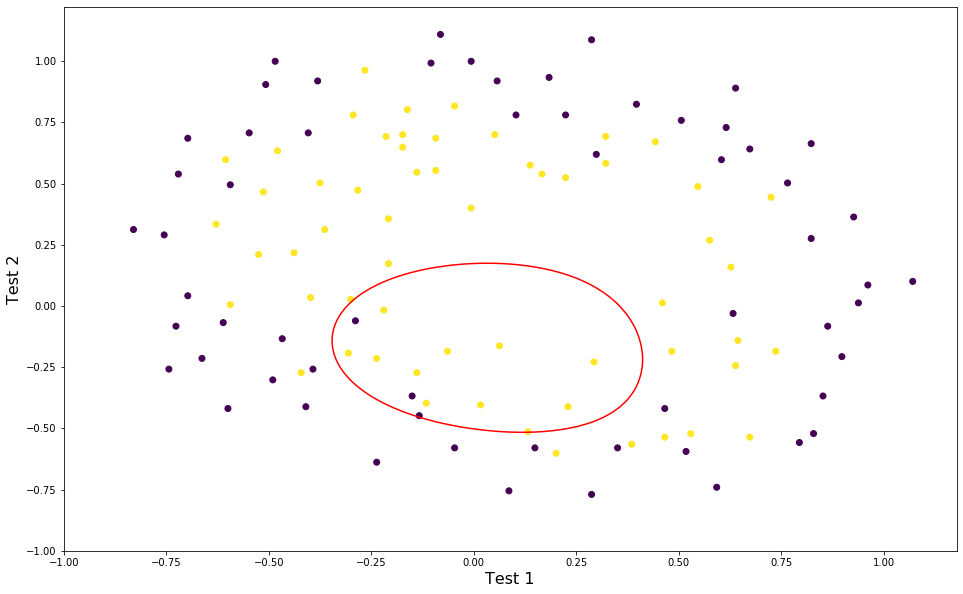

In [127]:
plot_data_and_model(X, y, result['model'])

### 14. Попробуйте различные значения параметра регуляризации λ. Как выбор данного значения влияет на вид разделяющей кривой? Ответ дайте в виде графиков.

C = 0


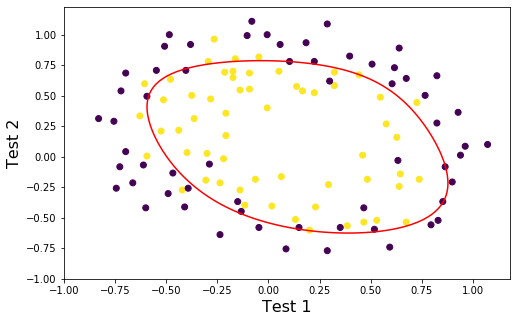

C = 0.01


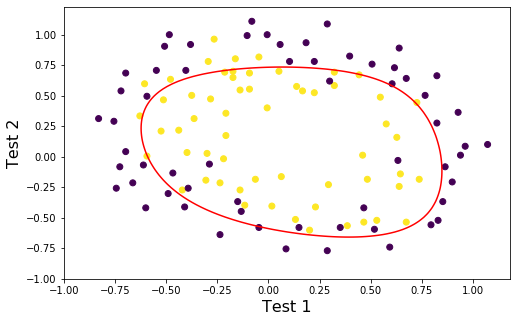

C = 0.1


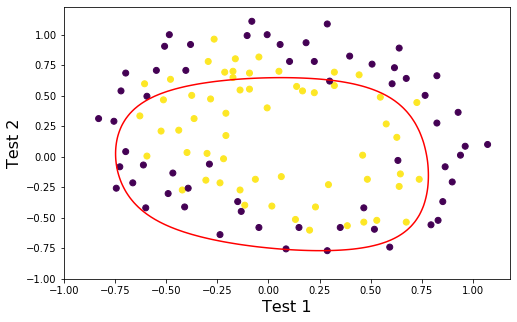

C = 0.25


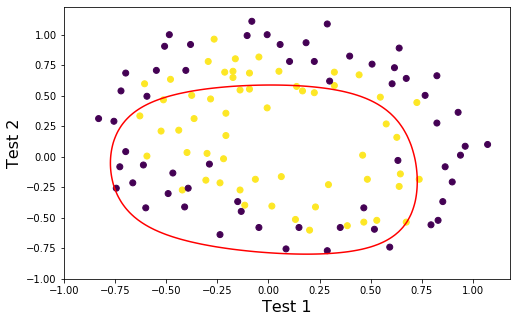

C = 0.5


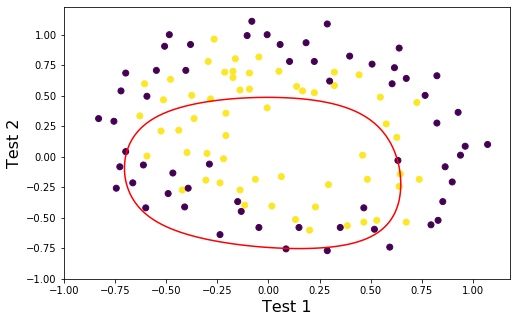

C = 1.0


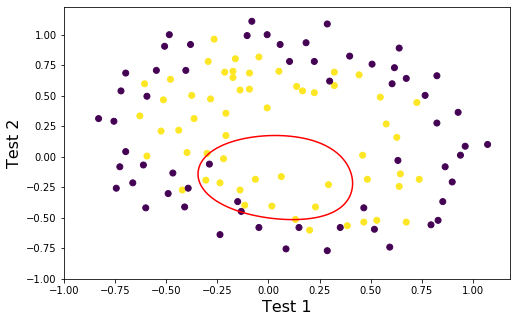

In [128]:
C_list = [0, 1e-2, 1e-1, 0.25, 0.5, 1.]

for C in C_list:
    print('C = {}'.format(C))
    
    W, b = get_initialization(dim=X_wide.shape[1])
    regularized_model = L2RegualizedLogisticRegression(W, b, C)

    gradient_descent = get_gradient_descent(regularized_model, 0.1, 1e-6)
    result = gradient_descent(X_wide, y)
    
    plot_data_and_model(X, y, result['model'], figsize=(8,5))

### 15. Загрузите данные ex2data3.mat из файла.

In [131]:
ex2data3 = io.loadmat('Data/Lab 2/ex2data3.mat')
X, y = ex2data3['X'], ex2data3['y'].flatten()

### 16. Визуализируйте несколько случайных изображений из набора данных. Визуализация должна содержать каждую цифру как минимум один раз.

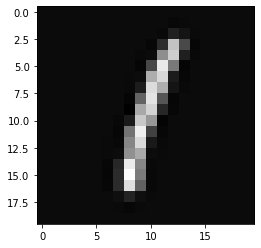

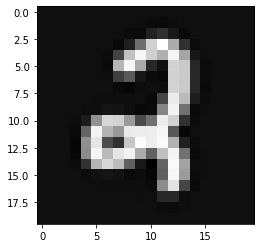

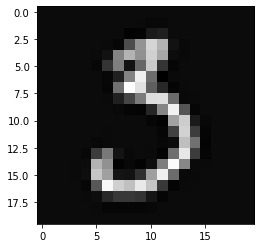

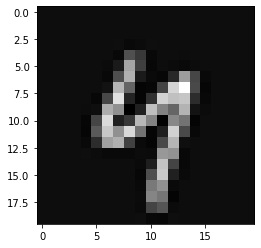

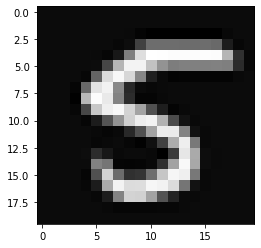

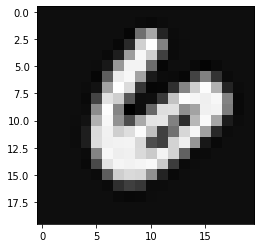

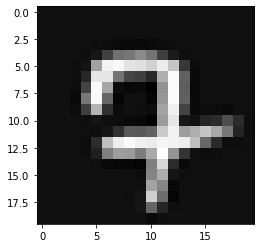

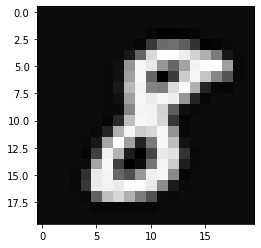

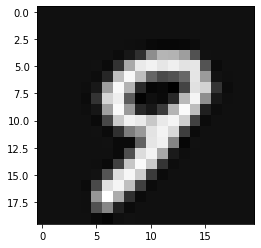

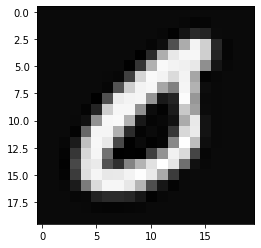

In [133]:
n = 1

for idx in range(1, 11):
    idx_range = np.where(y == idx)[0]
    idx_subset = np.random.choice(idx_range, size=n)
    
    images = X[idx_subset].reshape((n, 20, 20), order='F')
    for batch_idx in range(n):
        plt.imshow(images[0, :, :], cmap='gray')
        plt.show()

### 17. Реализуйте бинарный классификатор с помощью логистической регрессии с использованием векторизации (функции потерь и градиентного спуска).

In [135]:
X_norm = X - X.mean(axis=0)

y_new = y.copy()
y_new[y == 5] = 1
y_new[y != 5] = 0

In [ ]:
model = LogisticRegression(*get_initialization(dim=X_norm.shape[1]))
gradient_descent = get_gradient_descent(model, 0.1, 1e-6)

result = gradient_descent(X_norm, y_new)

### 18. Добавьте L2-регуляризацию к модели.

In [137]:
W, b = get_initialization(dim=X_norm.shape[1])
regularized_model = L2RegualizedLogisticRegression(W, b, 5e-4)

gradient_descent = get_gradient_descent(regularized_model, 0.1, 1e-6)
result = gradient_descent(X_norm, y_new)

### 19. Реализуйте многоклассовую классификацию по методу “один против всех”.

In [139]:
class OneVsRestClassifier:
    
    def __init__(self, base_model, alpha, eps=1e-6):
        self._base_model = base_model
        self._alpha = alpha
        self._eps = eps
        self._trained_models = OrderedDict()
    
    def fit(self, X, y):        
        for class_id in sorted(np.unique(y)):
            print('Fitting {} vs all'.format(class_id))
            model = deepcopy(self._base_model)
            assert model != self._base_model
            
            y_mocked = y.copy()
            y_mocked[y == class_id] = 1
            y_mocked[y != class_id] = 0
            
            gradient_descent = get_gradient_descent(model, self._alpha, self._eps)
            result = gradient_descent(X, y_mocked)
            self._trained_models[class_id] = result['model']
    
    def predict(self, X):
        return pd.DataFrame({class_id: model(X) for class_id, model in self._trained_models.items()})

### 20. Реализуйте функцию предсказания класса по изображению с использованием обученных классификаторов.

In [140]:
W, b = get_initialization(dim=X_norm.shape[1])
base_model = L2RegualizedLogisticRegression(W, b, 1e-5)

one_vs_all_model = OneVsRestClassifier(base_model, alpha=1.0)
one_vs_all_model.fit(X_norm, y)

Fitting 1 vs all
Fitting 2 vs all
Fitting 3 vs all
Fitting 4 vs all
Fitting 5 vs all
Fitting 6 vs all
Fitting 7 vs all
Fitting 8 vs all
Fitting 9 vs all
Fitting 10 vs all


### 21. Процент правильных классификаций на обучающей выборке должен составлять около 95%.

In [142]:
y_pred_probas = one_vs_all_model.predict(X_norm)
y_pred = y_pred_probas.idxmax(axis=1).to_numpy()

accuracy = np.sum(y == y_pred) / len(y)
print('Correct answers percent: {:.2%}'.format(accuracy))

Correct answers percent: 94.76%
